<a href="https://colab.research.google.com/github/ShaunakSen/Deep-Learning/blob/master/TensorFlow_Tutorial_03_C_Keras_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  TensorFlow Tutorial #03-C  Keras API

[link](https://www.youtube.com/watch?v=3yfRJKA1BiQ&list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ&index=6&t=1240s)

Tutorial #02 showed how to implement a Convolutional Neural Network in TensorFlow. We made a few helper-functions for creating the layers in the network. It is essential to have a good high-level API because it makes it much easier to implement complex models, and it lowers the risk of errors.

There are several of these builder API's available for TensorFlow: PrettyTensor (Tutorial #03), Layers API (Tutorial #03-B), and several others. But they were never really finished and now they seem to be more or less abandoned by their developers.

This tutorial is about the Keras API which is already highly developed with very good documentation - and the development continues. It seems likely that Keras will be the standard API for TensorFlow in the future so it is recommended that you use it instead of the other APIs.

The author of Keras has written a [blog-post](https://blog.keras.io/user-experience-design-for-apis.html) on his API design philosophy which you should read.

In [5]:
import os
work_dir = "/content/TensorFlow-Tutorials/"
if os.getcwd() != work_dir:
  !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials
os.chdir(work_dir)

fatal: destination path 'TensorFlow-Tutorials' already exists and is not an empty directory.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

We need to import several things from Keras. Note the long import-statements. This might be a bug. Hopefully it will be possible to write shorter and more elegant lines in the future.



In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

In [7]:
tf.__version__


'1.14.0'

### Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.



In [0]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [9]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [11]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = data.img_shape_full

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

print (img_size, img_size_flat, img_shape, img_shape_full, num_classes, num_channels)

28 784 (28, 28) (28, 28, 1) 10 1


### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.



In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Plot a few images to see if data is correct

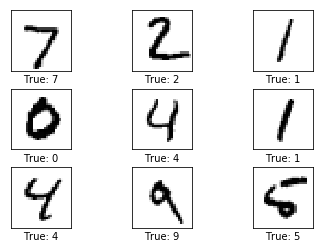

In [13]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.



In [0]:
def plot_example_errors(cls_pred):
  # cls_pred is an array of the predicted class-number for
  # all images in the test-set.
  
  # Boolean array whether the predicted class is incorrect.
  incorrect = (data.y_test_cls != cls_pred)
  
  # Get the images from the test-set that have been
  # incorrectly classified.
  images = data.x_test[incorrect]
  
  # Get the predicted classes for those images.
  cls_pred = cls_pred[incorrect]
  
  # Get the true classes for those images.
  cls_true = data.y_test_cls[incorrect]
    
  # Plot the first 9 images.
  plot_images(images=images[0:9],
              cls_true=cls_true[0:9],
              cls_pred=cls_pred[0:9])

    
  
  

### Sequential Model

The Keras API has two modes of constructing Neural Networks. The simplest is the Sequential Model which only allows for the layers to be added in sequence.



In [0]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.

model.add(InputLayer(input_shape=(img_size_flat,)))

# The input is a flattened array with 784 elements,
# but the convolutional layers expect images with shape (28, 28, 1)

model.add(Reshape(target_shape=img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.

model.add(Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.

model.add(Conv2D(filters=36, kernel_size=5, strides=1, padding='same', activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(units=128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(units=num_classes, activation='softmax'))

### Model Compilation

The Neural Network has now been defined and must be finalized by adding a loss-function, optimizer and performance metrics. This is called model "compilation" in Keras.

We can either define the optimizer using a string, or if we want more control of its parameters then we need to instantiate an object. For example, we can set the learning-rate if we do the latter

In [0]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

For a classification-problem such as MNIST which has 10 possible classes, we need to use the loss-function called categorical_crossentropy. The performance metric we are interested in is the classification accuracy.



In [0]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Training

Now that the model has been fully defined with loss-function and optimizer, we can train it. This function takes numpy-arrays and performs the given number of training epochs using the given batch-size. An epoch is one full use of the entire training-set. So for 10 epochs we would iterate randomly over the entire training-set 10 times.



In [22]:
model.fit(x=data.x_train, y=data.y_train, batch_size=128, epochs=1)

55000/55000 [==============================] - 6s 107us/sample - loss: 0.2216 - acc: 0.9348


### Evaluation

Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.



In [23]:
result = model.evaluate(x=data.x_test, y=data.y_test)

10000/10000 [==============================] - 1s 114us/sample - loss: 0.0598 - acc: 0.9805


In [24]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.059782084504049274
acc 0.9805


In [28]:
# Or we can just print the classification accuracy.

print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))


acc: 98.05%


### Prediction

We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.



In [29]:
# get the first 9 test images

images = data.x_test[0:9]

# These are the true class-number for those images. This is only used when plotting the images.

cls_true = data.y_test_cls[0:9]

# Get the predicted classes as One-Hot encoded arrays.

y_pred = model.predict(x=images)

print (y_pred.shape)

(9, 10)


In [30]:
# Get the predicted classes as integers.

cls_pred = np.argmax(y_pred, axis=1)

print (cls_pred.shape)

(9,)


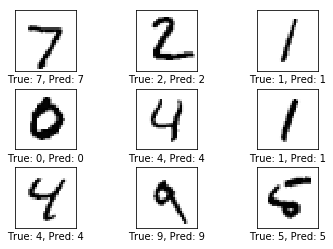

In [31]:
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

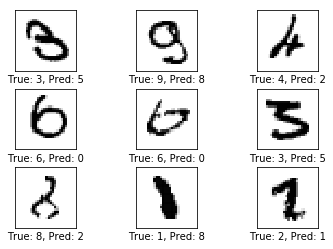

In [32]:
y_pred = model.predict(x=data.x_test)

# Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

cls_pred = np.argmax(y_pred, axis=1)

# Plot some of the mis-classified images.

plot_example_errors(cls_pred)
